In [1]:
## run this first!
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(cowplot)

options(repr.matrix.max.rows=10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Final Project: Optimized Classifier: Assessment of Regional Predictor Differences and Influence on Heart Disease Diagnoses  

### Introduction
The heart disease data includes datasets from Cleveland, California, Budapest, and Zurich (Dua et al., 2019). We will focus on Cleveland because it is the most complete. Out of the 14 variables, 9 are categorical variables, variables that we can potentially predict by building a classifier (Dua et al., 2019).  

CT scans to see potential blockages in arteries as a method of preventative care are avoided by public healthcare systems (Levine, 2019, p. 3) or costly with private healthcare (Berenson et al., 2008, p. 1; Weinick et al., 2005, p. 3; Lu, 2021, p. 577). An accurate predictor could serve as a cheaper and more efficient alternative. There’s a dearth in understanding of whether optimal accuracy is achieved by building individual classifiers per region or by accumulating a large training set.

Preliminarily, numerical indicators include age (age), resting blood pressure (trestbps), serum cholesterol levels (chol), maximum heart rate achieved (thalach), and ST depression induced by exercise relative to rest (oldpeak) (Dua et al., 2019).
We will aim to answer the following research question using numerical predictors:

1. Are all numerical predictors relevant to building an optimally accurate classifier? If not, which ones should we remove?


## Methods & Results:
### Preliminary Data Wrangling and Tidying 
1. Predictors age, trestbps, chol, thalach, oldpeak were 5 numerical predictors for the positive or negative diagnosis of heart disease (Dua et al., 2019).  All numerical predictors are potential candidates.  There were no obvious irrelevant predictors that we preliminarily filtered out because none were deemed to be prominent irrelevant predictors of heart disease.  Preliminary filter Method adapted from Data Science: A first Introduction textbook (Timbers et al., 2022)

    a. Rows, where the heart disease (num) column equals 2, 3, 4, were filtered out, as it was not defined in the data summary.
    
    b.
    
    i.age,  trestbps, thalach, chol, oldpeak are selected as numerical predictors
        
    ii. num is selected to predict heart disease diagnoses. 


2. Mutate function was used on our data.
    
    a. as_factor was used to convert num into a fct from dbl. 
3. Data was split into testing and training sets.
4. Preview the number of heart diseases vs. the number of no heart disease diagnoses to check for potential data imbalances. 
5. The training set was upscaled, so a balance of the categorial variable is achieved.

### Preliminary Exploratory Visualizations
1. Use Visualizations were used in the proposal to understand which variables are potentially relevant.  This method, however, is cumbersome, error-prone, and distracts the reader from the crux of the research findings (Timbers et al., 2022).  
2. Visualizations indicated mostly proportional fluctuations between positive and negative heart disease diagnosis bars.  This indicated that visualizations do not provide visually significant differences between the effect of predictors on whether the heart disease is positive or negative.
3. We have removed it from the final project, but such visualizations can still be found in the proposal. 

### Building the Classifier and Forward Selection

1. Building each classifier with optimal accuracy using v=5 cross-validation with Cleveland upscaled training set.

2. Forward Selection (Eforymson, 1995; Draper et al., 1996; Timbers et al., 2022)

a. The code in R was adapted from the textbook (Timbers et al., 2022).
    i. The code builds 15 classifiers with optimal K tuned for 15 classifiers listed below.
    ii. Display the maximum accuracy per predictor（...）.

b. The forward selection method was chosen because: 
i. Its required computation power was more reasonable than the best subset selection method (Timbers et al., 2022).
ii. Works well with large data and a small number of predictors. Our dataset has a small number of predictors but not a large dataset. Checkout “Testing True Accuracy with Testing Set” to see how this is mitigated.

3. Build classifiers via (m is the number of predictors (5)):

a. 5 (m)  classifiers with 1 numerical predictor for each predictor.

b. 4 (m-1) classifiers with 2 predictors

c. 3 (m-2) classifiers with 3 predictors 

d. 2 (m-3) classifiers with 4 predictors

e. 1 (m-4) classifier with 5 predictors.

f. The systematic approach is elaborated in the tibble below.


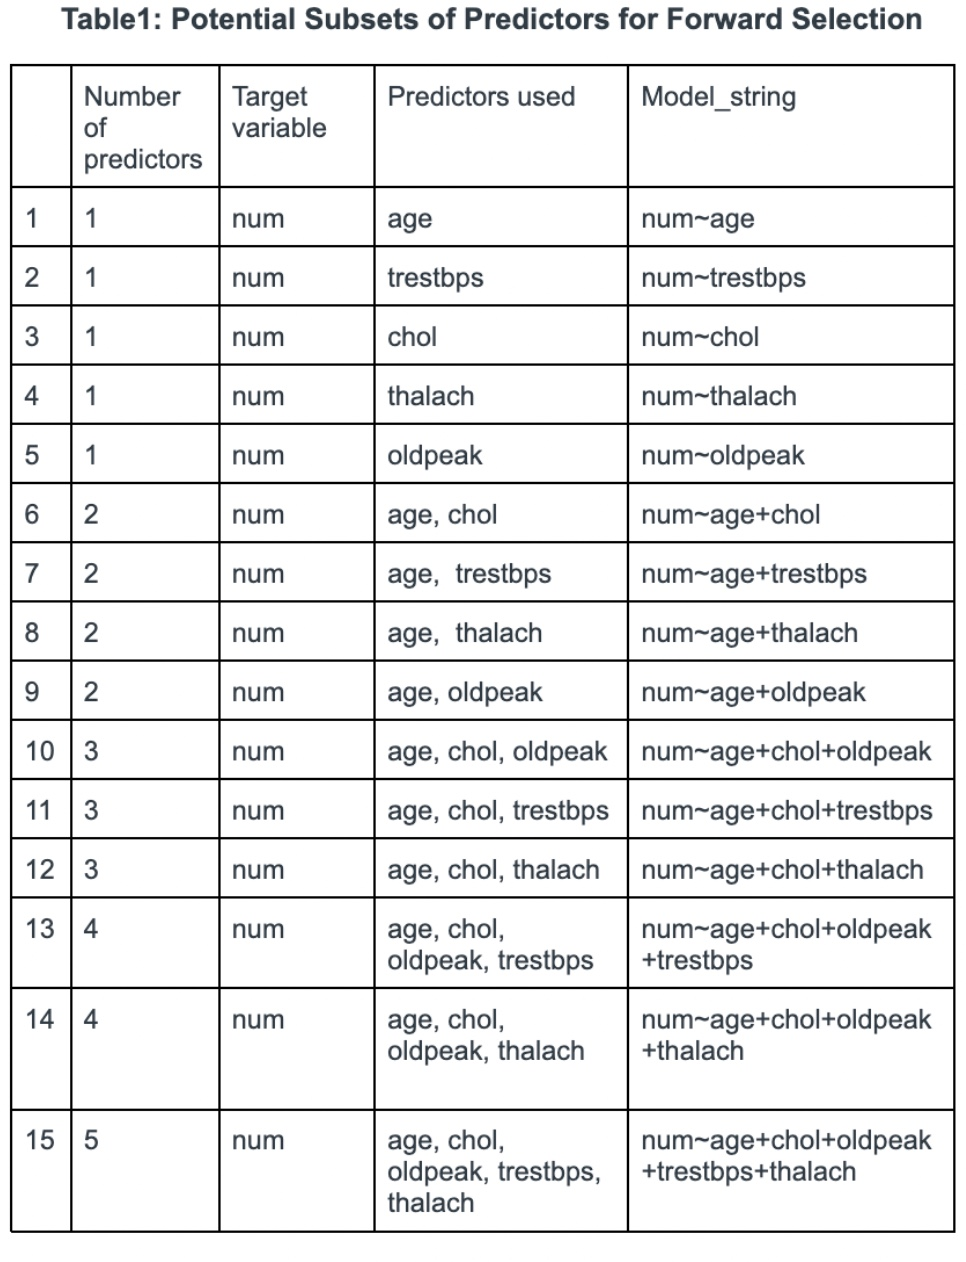

### Data summary

1. Only classifiers with the maximum accuracy per number of predictors were printed to present the most important data.

    a. For example, for one predictor, only the accuracy of the highest accuracy was printed alongside its model string.

### Testing true accuracy with Testing Set

1. Based on the summary of classifiers provided, the true accuracy was computed with testing data split earlier.  This is to see if there are scenarios with high estimator accuracy but low true accuracy (Timbers et al., 2022).  

### Visualization 

1. (Figure 1) Simultaneous line and scatter plot is plotted.
Number of predictors on the x-axis

    a. Estimated cross-validation accuracy on the y-axis. 

2. (Figure 2) An accompanying line and scatter plot are plotted.
Number of predictors on the x-axis

    b. Estimated accuracy using testing data on the y-axis.



### Reading, Tidying, and Wrangling Data

Firstly, we read two datasets(processed.cleveland.data & reprocessed.hungarian.data) directly from the web, gave every column a specific header name, selected the columns we are interested in, and converted every column into the correct and most appropriate data type. Then, all of the datasets are in a tidy format. 

Secondly, we split every dataset into a training set and a testing set where strata = num, ensuring that roughly the same proportion of 0 and 1(0 means no diagnosis; 1 means diagnosed) ends up in both training and testing sets. In the following steps, we will only analyze, summarize, and visualize the training sets of the two datasets.

In [3]:
set.seed(18)
con_names1<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang", "oldpeak","slope","ca","thal","num")
heart_cleveland<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = con_names1)

cleveland_mutate<-heart_cleveland|>
filter(num==0|num==1)|>
select(age,sex,cp,trestbps,chol,thalach,oldpeak,num)|>
mutate(age=as.integer(age))|>
mutate(num=as.factor(num))|>
mutate(cp=as.factor(cp))|>
mutate(sex=as.factor(sex))|>
mutate(trestbps=as.double(trestbps))|>
mutate(thalach=as.double(thalach))|>
mutate(oldpeak=as.double(oldpeak))

cleveland_split <- initial_split(cleveland_mutate, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training
cleveland_testing#print training data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,2.3,0
37,1,3,130,250,187,3.5,0
41,0,2,130,204,172,1.4,0
56,1,2,120,236,178,0.8,0
57,0,4,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,1,3,152,212,150,0.8,1
63,0,4,124,197,136,0.0,1
57,0,4,140,241,123,0.2,1


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,1,4,140,203,155,3.1,1
57,1,4,140,192,148,0.4,0
56,0,2,140,294,153,1.3,0
64,1,1,110,211,144,1.8,0
58,0,3,120,340,172,0.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,1,4,160,228,138,2.3,0
71,0,4,112,149,125,1.6,0
66,0,3,146,278,152,0.0,0


In [4]:
#Code Source: ...

set.seed(18)
#select 5 numerical variables from the cleveland training dataset
cleveland_training_subset <- cleveland_training |> 
  select(age, 
         trestbps, 
         chol, 
         thalach, 
         oldpeak, 
         num)

cleveland_testing_subset <- cleveland_testing |> 
  select(age, 
         trestbps, 
         chol, 
         thalach, 
         oldpeak, 
         num)
#extract variable names from the cleveland training sub dataset
names <- colnames(cleveland_training_subset |> select(-num))

names

cleveland_training_subset
cleveland_testing_subset

[1] "age"      "trestbps" "chol"     "thalach"  "oldpeak"

age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
37,130,250,187,3.5,0
41,130,204,172,1.4,0
56,120,236,178,0.8,0
57,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮
67,152,212,150,0.8,1
63,124,197,136,0.0,1
57,140,241,123,0.2,1


age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,140,203,155,3.1,1
57,140,192,148,0.4,0
56,140,294,153,1.3,0
64,110,211,144,1.8,0
58,120,340,172,0.0,0
⋮,⋮,⋮,⋮,⋮,⋮
66,160,228,138,2.3,0
71,112,149,125,1.6,0
66,146,278,152,0.0,0


In [5]:
number_of_heartdisease_vs_no_heart_disease<-cleveland_training_subset|>
group_by(num)|>
summarize(n=n())|>
mutate("Diagnosis_of_heart_disease"=num)|>
mutate("Number"=n)|>
select(-num,-n)

levels(number_of_heartdisease_vs_no_heart_disease$Diagnosis_of_heart_disease) <- c("negative","positive")  # changes 1,2,3 to "Karma", "Rosa", "Canadian"

number_of_heartdisease_vs_no_heart_disease


percentage_of_heartdisease <- cleveland_mutate|>
summarize("percentage of positive heart disease (%)"= sum(num==1))*100/nrow(cleveland_mutate)


percentage_of_heartdisease


Diagnosis_of_heart_disease,Number
<fct>,<int>
negative,123
positive,41


percentage of positive heart disease (%)
<dbl>
25.11416


**Figure 4(a,b)** *4A is the top tibble, 4B is the bottom tibble. Individuals with negative diagnosis supercede number of individuals with a positive diagnosis, this resulted in an imbalance in the categorial variable we're trying to predict. K-nearest neighbors classification may not perform well with imbalance of cateorical variable.  The percentage of positive heart disease is 25% which is significantly less than the 75% of negataive heart diseaase. Therefore we have to upsample the data, this rebalances the data by multiplying the rarer class, "positive" (Timbers et al., 2022).*

In [6]:
ups_recipe <- recipe(num~., data = cleveland_training_subset)|>
step_upsample(num, over_ratio = 1, skip = FALSE)|>
prep()

upsampled_cleveland_training_subset <- bake(ups_recipe, cleveland_training_subset)

unsampled_heaartdisease<-upsampled_cleveland_training_subset|>
group_by(num)|>
summarize(n=n())


upsampled_cleveland_training_subset

age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
37,130,250,187,3.5,0
41,130,204,172,1.4,0
56,120,236,178,0.8,0
57,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮
59,134,204,162,0.8,1
44,110,197,177,0.0,1
57,150,276,112,0.6,1


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.7231667,5,0.02564230,Preprocessor1_Model7
15,accuracy,binary,0.7070000,5,0.02709243,Preprocessor1_Model8
11,accuracy,binary,0.6746667,5,0.01827757,Preprocessor1_Model6
9,accuracy,binary,0.6585000,5,0.01607794,Preprocessor1_Model5
7,accuracy,binary,0.6090000,5,0.02951271,Preprocessor1_Model4
6,accuracy,binary,0.4958333,5,0.02642337,Preprocessor1_Model3
4,accuracy,binary,0.4838333,5,0.02402487,Preprocessor1_Model2
2,accuracy,binary,0.4836667,5,0.01644139,Preprocessor1_Model1


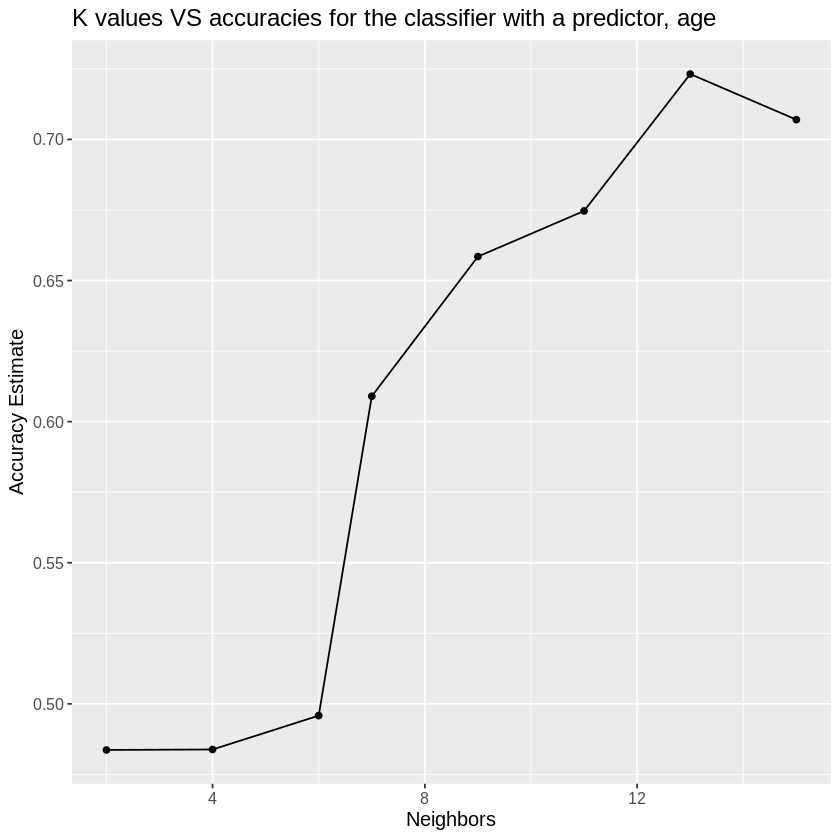

In [7]:
set.seed(18)
#Visualization for the cross vlidation
example_vfold <- vfold_cv(upsampled_cleveland_training_subset, v = 5, strata = num)

example_recipe <- recipe(num ~ age, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# neighbors = tune() helps us find the best K from a set of K values 
example_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

example_results <- workflow() |>
  add_recipe(example_recipe) |>
  add_model(example_spec) |>
  tune_grid(resamples = example_vfold, grid = 10) |>
  collect_metrics()


example_accuracies <- example_results |>
  filter(.metric == "accuracy")

arranged_example_accuracies <- example_accuracies|>
arrange(desc(mean))

arranged_example_accuracies

# check for most optimal accuracy, and it is usually the highest and most stable one.

# plot of K values against their respective accuracies
example_cross_val_plot <- example_accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("K values VS accuracies for the classifier with a predictor, age")+
    theme(text = element_text(size = 12))

example_cross_val_plot

In [8]:
set.seed(18)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heartdisease_vfold <- vfold_cv(upsampled_cleveland_training_subset, v = 5, strata = num)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("num", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        hd_recipe <- recipe(as.formula(model_string), 
                                data = upsampled_cleveland_training_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        
            # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heartdisease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy")|>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()


        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies    

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ age,0.7231667
2,num ~ age+chol,0.8290000
3,num ~ age+chol+oldpeak,0.8375000
4,num ~ age+chol+oldpeak+trestbps,0.8583333
5,num ~ age+chol+oldpeak+trestbps+thalach,0.8418333


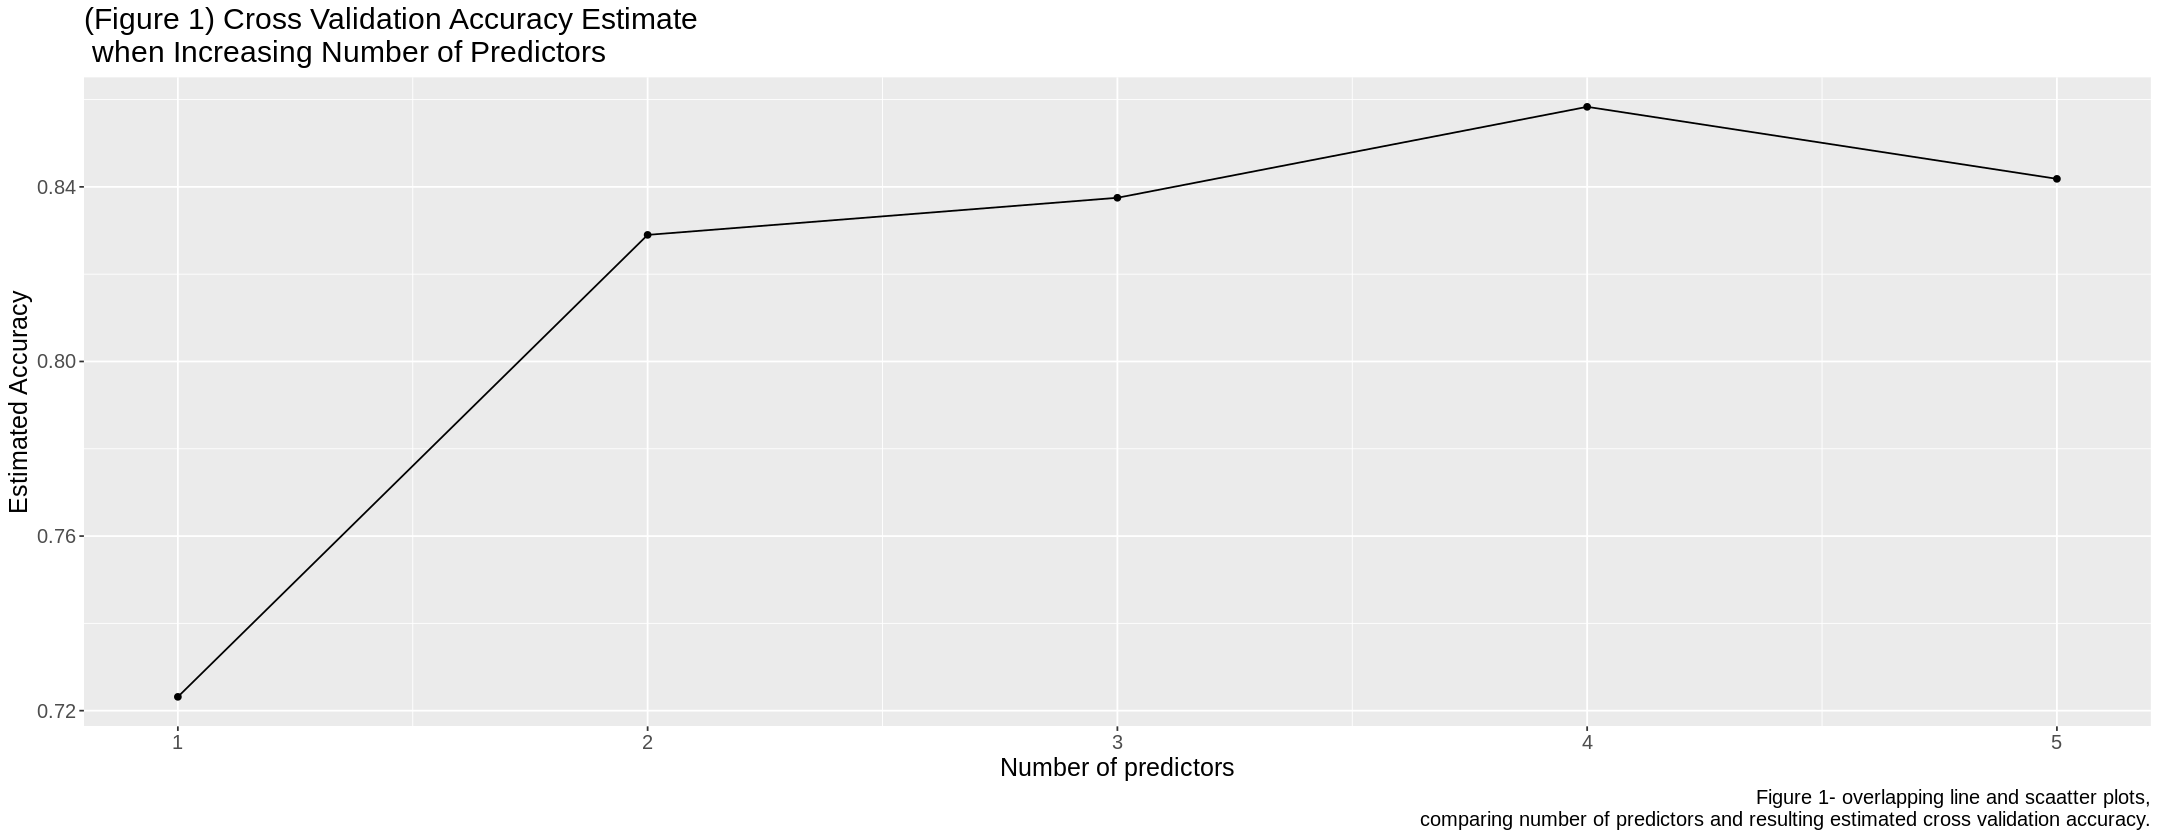

In [9]:
options(repr.plot.width=18, repr.plot.height=7)
accuracies_cross_validation_plot<-accuracies|>
ggplot(aes(x=size,y=accuracy))+
geom_point()+
geom_line()+
labs(x="Number of predictors",y="Estimated Accuracy",
     caption ="Figure 1- overlapping line and scaatter plots,
comparing number of predictors and resulting estimated cross validation accuracy.")+
theme(text=element_text(size=20))+
ggtitle("(Figure 1) Cross Validation Accuracy Estimate \n when Increasing Number of Predictors")+
theme(text = element_text(size = 15))


accuracies_cross_validation_plot

In [10]:
set.seed(18)
#test the five classifiers on the testing dataset

heartDisease_vfold <- vfold_cv(upsampled_cleveland_training_subset, v = 5, strata = num)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
#neighbors vs cross vaalidation accuracy

recipe_size1 <- recipe(num ~ trestbps, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size1 <- workflow() |>
  add_recipe(recipe_size1) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size1 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size1) |>
         set_engine("kknn") |>
         set_mode("classification")


accuracy_testing_dataset_size1 <- workflow() |>
         add_recipe(recipe_size1) |>
         add_model(best_spec_size1) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)
          


recipe_size2 <- recipe(num ~ trestbps+age, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size2 <- workflow() |>
  add_recipe(recipe_size2) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size2) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size2 <- workflow() |>
         add_recipe(recipe_size2) |>
         add_model(best_spec_size2) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)


recipe_size3 <- recipe(num ~ trestbps+age+oldpeak, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size3 <- workflow() |>
  add_recipe(recipe_size3) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size3 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size3) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size3 <- workflow() |>
         add_recipe(recipe_size3) |>
         add_model(best_spec_size3) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)

recipe_size4 <- recipe(num ~ trestbps+age+oldpeak+chol, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size4 <- workflow() |>
  add_recipe(recipe_size4) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size4 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size4) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size4 <- workflow() |>
         add_recipe(recipe_size4) |>
         add_model(best_spec_size4) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)


recipe_size5 <- recipe(num ~ trestbps+age+oldpeak+chol+thalach, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size5 <- workflow() |>
  add_recipe(recipe_size5) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size5 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size5) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size5 <- workflow() |>
         add_recipe(recipe_size5) |>
         add_model(best_spec_size5) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)
###

accuracy_testing_dataset_size1
accuracy_testing_dataset_size2
accuracy_testing_dataset_size3
accuracy_testing_dataset_size4
accuracy_testing_dataset_size5

[1] 0.6

[1] 0.5090909

[1] 0.6

[1] 0.6727273

[1] 0.6545455

In [11]:
size<-list(1, 2, 3, 4, 5)
model_string<-list("num ~ age", "num ~ age+chol",
                   "num ~ age+chol+oldpeak",
                   "num ~ age+chol+oldpeak+trestbps",
                   "num ~ age+chol+oldpeak+trestbps+thalach")
accuracy <- list(accuracy_testing_dataset_size1,
accuracy_testing_dataset_size2,
accuracy_testing_dataset_size3,
accuracy_testing_dataset_size4,
accuracy_testing_dataset_size5)



testing_accuracies<-tibble(size|>unlist(), model_string|>unlist(), accuracy|>unlist())|>
rename(size="unlist(size)", model_string="unlist(model_string)",accuracy="unlist(accuracy)")
col_names <- c("size", "model_string", "accuracy")

testing_accuracies

size,model_string,accuracy
<dbl>,<chr>,<dbl>
1,num ~ age,0.6000000
2,num ~ age+chol,0.5090909
3,num ~ age+chol+oldpeak,0.6000000
4,num ~ age+chol+oldpeak+trestbps,0.6727273
5,num ~ age+chol+oldpeak+trestbps+thalach,0.6545455


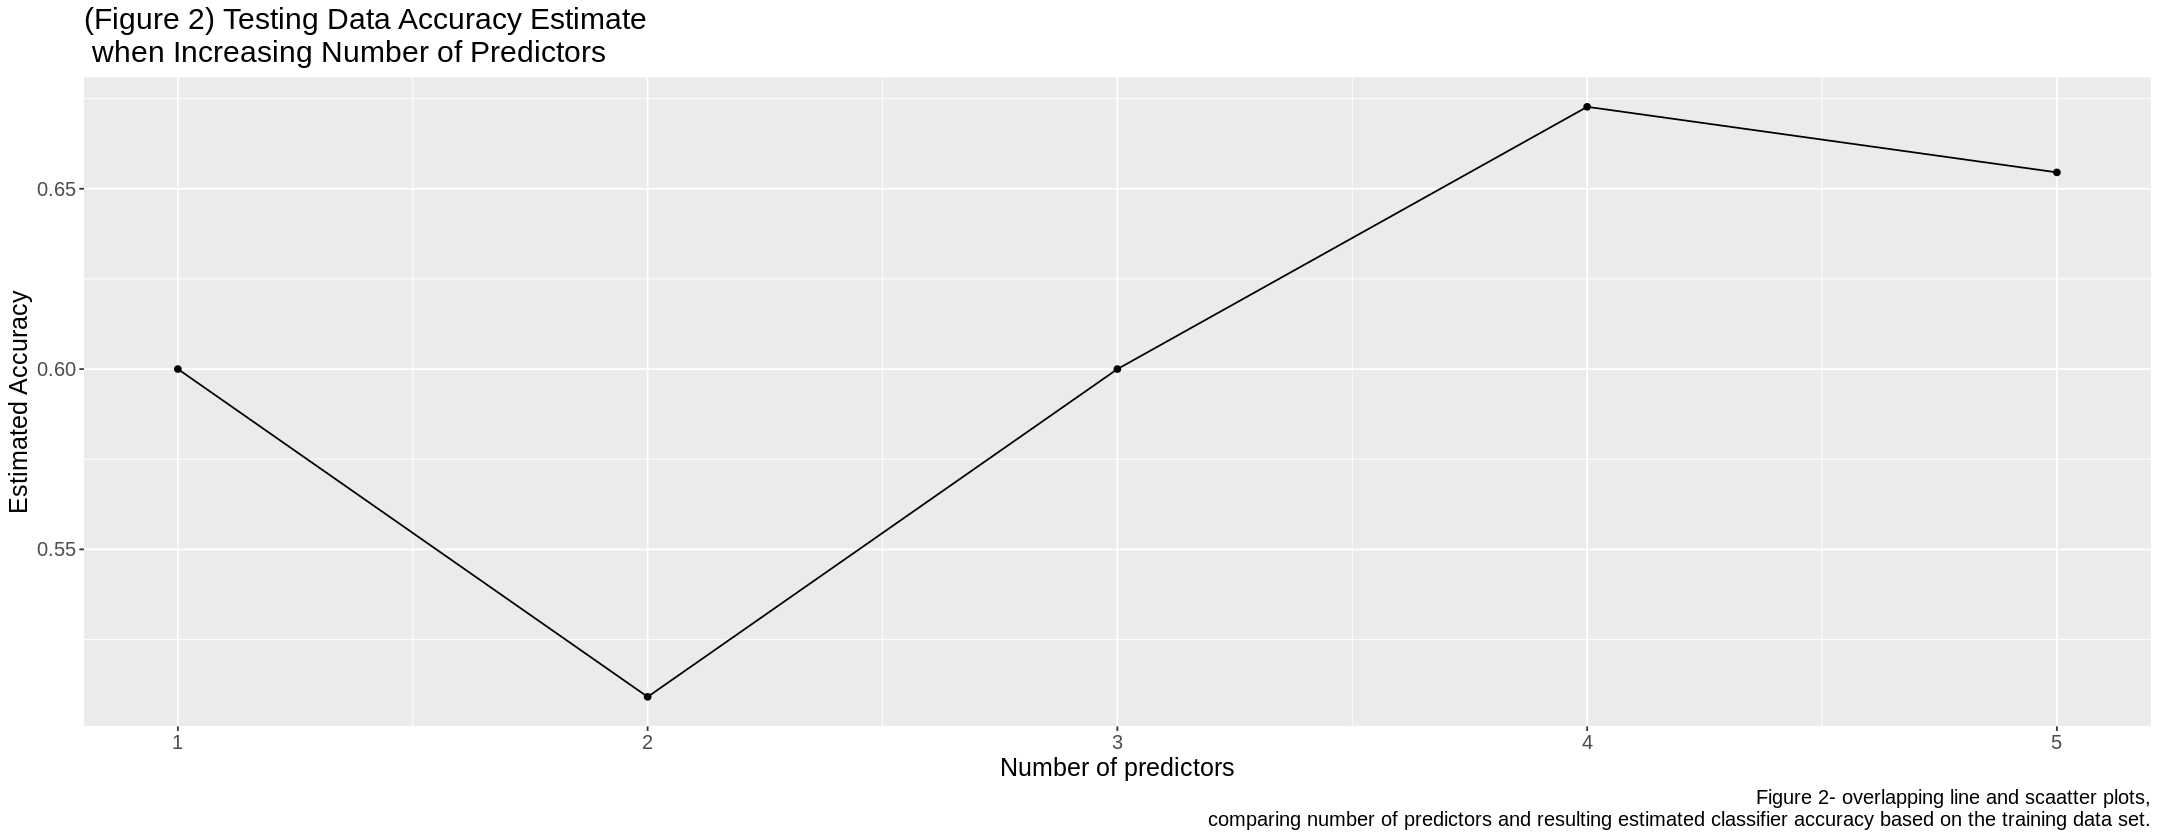

In [14]:
options(repr.plot.width=18, repr.plot.height=7)
accuracies_testing_data_plot<-testing_accuracies|>
ggplot(aes(x=size,y=accuracy))+
geom_point()+
geom_line()+
labs(x="Number of predictors",y="Estimated Accuracy",
     caption ="Figure 2- overlapping line and scaatter plots,
comparing number of predictors and resulting estimated classifier accuracy based on the training data set.")+
theme(text=element_text(size=20))+
ggtitle("(Figure 2) Testing Data Accuracy Estimate \n when Increasing Number of Predictors")+
theme(text = element_text(size = 15))


accuracies_testing_data_plot

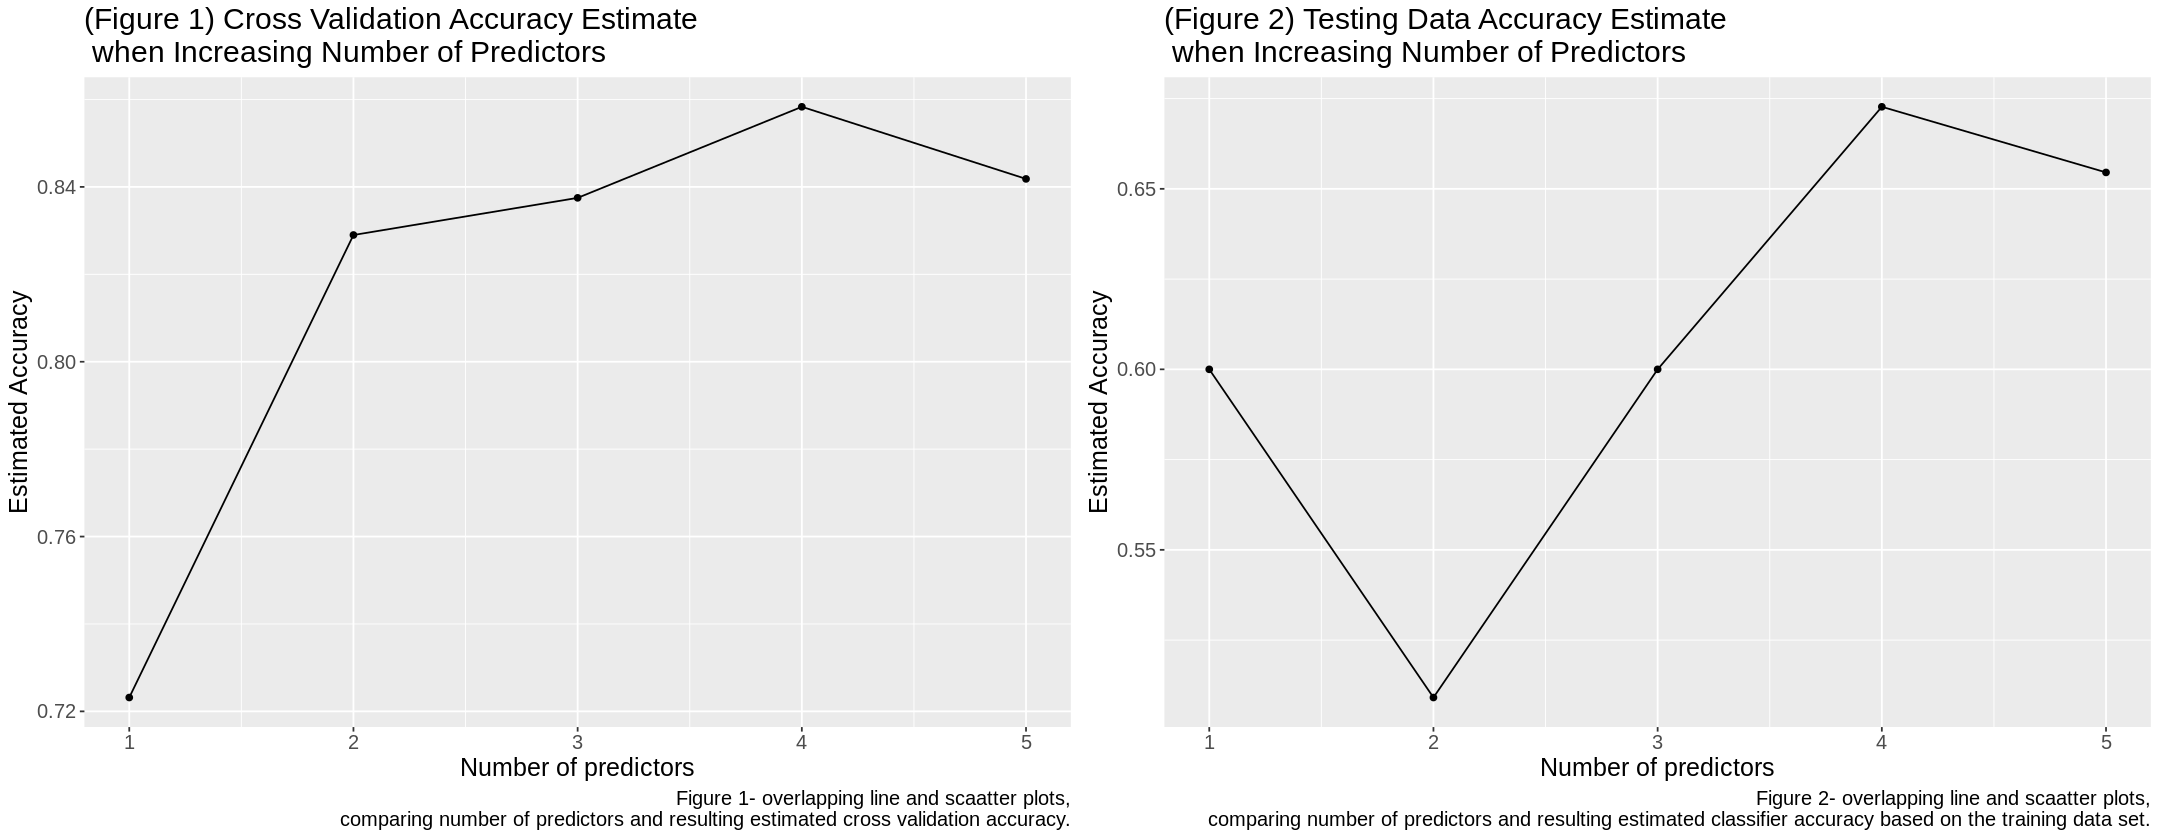

In [15]:
plot_grid(accuracies_cross_validation_plot, accuracies_testing_data_plot, ncol = 2)

                                                     References

Berenson, A., & Reed, A. (2008). Weighing the Costs of a CT Scan’s Look Inside the Heart. https://www.nytimes.com/2008/06/29/business/29scan.html

Dua, D., & Graff, C. (2019). {UCI} Machine Learning Repository. University of California, Irvine, School of Information and 
>Computer Sciences, http://archive.ics.uci.edu/ml

Draper, Norman, and Harry Smith. (1966). Applied Regression Analysis. Wiley.
>Eforymson, M. (1966). “Stepwise Regression—a Backward and Forward Look.” In Eastern Regional Meetings of the Institute of Mathematical Statistics.

Levine, S., Malone, E., Lekiachvili, A., & Briss, P. (2019). Health Care Industry Insights: Why the Use of Preventive Services 
>Is Still Low. Health Care Systems, Public Health, and Communities: Population Health Improvements, 16 http://dx.doi.org/10.5888/pcd16.180625

Lu, P., Kong, D., & Shelley, M. (2021). Risk Perception, Preventive Behavior, and Medical Care Avoidance among American Older 
>Adults During the COVID-19 Pandemic. Journal of Aging and Health. https://doi.org/10.1177_08982643211002084

Timbers, T., Campbell, T., & Lee, M. (2022). Chapter 6 Classification II: evaluation & tuning. In R. Peng (Ed.), Data Science A 
>First Introduction ()

Weinick, R. M., Byron, S. C., & Bierman, A. S. (2005). Who Can't Pay for Health Care? Journal of General Internal Medicine, 
>20(6), 504-509. https://doi.org/10.1111/j.1525-1497.2005.0087.x


 



Note: This is not exactly formatted like APA because it's difficult to replicate with markdown, screenshot hidden below provides accurate formatting.  Click aarrow on the left to view.

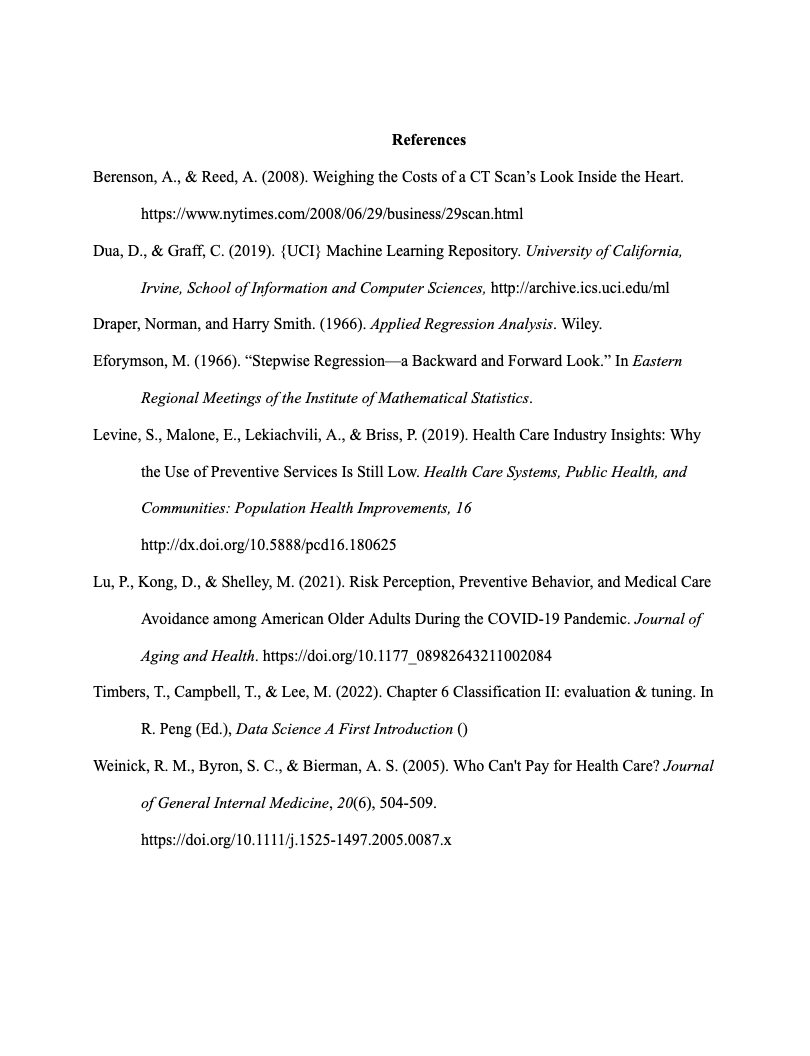